<a href="https://colab.research.google.com/github/SidorenkArtem/AWS-dataset/blob/master/EC2-ELB(version-2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_costs.csv to cleaned_costs.csv


In [3]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "cleaned_costs.csv" with length 30280 bytes


In [0]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
from keras.regularizers import L1L2
from keras.optimizers import RMSprop

def series_to_supervised(data, step_back=1, step_forward=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(step_back, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, step_forward):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
def prepare_data(series, n_test, step_back, step_forward):

	raw_values = series.values
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	supervised = series_to_supervised(scaled_values, step_back, step_forward)
	supervised_values = supervised.values
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test
 
def fit_lstm(train, step_back, n_batch, nb_epoch, n_neurons):
  X, y = train[:, 0:step_back], train[:, step_back:]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(n_neurons,dropout=0.3,recurrent_dropout=0.5,
                 return_sequences = True, 
                 batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                 stateful=True,
                 kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
  model.add(LSTM(n_neurons,dropout=0.3,recurrent_dropout=0.5,
                 return_sequences = True, 
                 batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                 stateful=True,
                 kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
  model.add(LSTM(n_neurons,dropout=0.3,recurrent_dropout=0.5,
                 stateful=True,
                 kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
  model.add(Dense(y.shape[1]))
  model.compile(loss='mae', optimizer=RMSprop())
  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
    model.reset_states()
  return model
 
def forecast_lstm(model, X, n_batch):
	X = X.reshape(1, 1, len(X))
	forecast = model.predict(X, batch_size=n_batch)
	return [x for x in forecast[0, :]]
 
def make_forecasts(model, n_batch, test, step_back):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:step_back], test[i, step_back:]
		forecast = forecast_lstm(model, X, n_batch)
		forecasts.append(forecast)
	return forecasts
 
def inverse_difference(last_ob, forecast):
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		inverted.append(inv_diff)
	return inverted
 
def evaluate_forecasts(test, forecasts, step_forward):
	for i in range(step_forward):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
def plot_forecasts(series, forecasts, n_test):
	pyplot.plot(series.values)
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	pyplot.show()
 
series = read_csv('cleaned_costs.csv', usecols=[4], engine='python')

step_back = 6
step_forward = 2
n_test = 60
n_epochs = 100
n_batch = 1
n_neurons = 4
scaler, train, test = prepare_data(series, n_test, step_back, n_seq)
model = fit_lstm(train, step_back, n_batch, n_epochs, n_neurons)

t+1 RMSE: 0.679962
t+2 RMSE: 0.989682


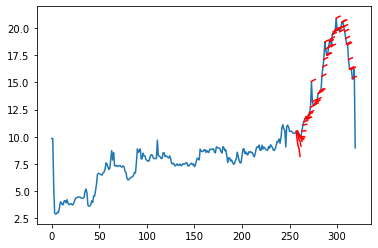

In [52]:
forecasts = make_forecasts(model, n_batch, test, step_back)
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[step_back:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
evaluate_forecasts(actual, forecasts,  step_forward)
plot_forecasts(series, forecasts, n_test+2)

Test Score: 0.68 RMSE


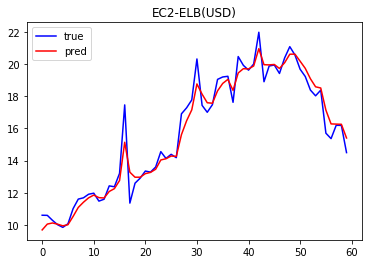

In [53]:
from matplotlib import pyplot as plt
import numpy as np
import math
def plot_test():
  a = np.asarray(actual, dtype=np.float32)
  b = np.asarray(forecasts, dtype=np.float32)
  
  a1 = a[:,0]
  b1 = b[:,0]
  a1 = a1.reshape(len(a1),1)
  b1 = b1.reshape(len(b1),1)
  
  testScore = math.sqrt(mean_squared_error(a1[:, 0], b1[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  temp = a1[:len(a1)]
  temp1 = b1[:len(b1)]
  plt.title('EC2-ELB(USD)')
  plt.plot(range(len(temp)), temp, 'b',label = 'true')
  plt.plot(range(len(temp1)), temp1, 'r', label = 'pred')
  plt.legend()
  plt.show()

plot_test()